# Calculate and glacier terminus positions at different dates
### Jukes Liu

Files used:
    - Terminus box left midpoints and centerlines (Boxes_coords_pathrows.csv)
    - Terminus chains picked by size (terminuspicks_size_2019_07_24.csv)
    - Terminus chains picked by mass (terminuspicks_mass_2019_07_24.csv)
    - DateTimes of satellite images (datetags.csv)

### Set up: Import packages, read in csv files

In [1044]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.image as mpimg
import datetime
import types
import os
import cv2

basepath = '/home/jukes/Documents/Sample_glaciers/'

#set date for the terminus picks analyzed
d8 = '2019_10_02'

In [1045]:
#Read in file with box coordinates
box_df = pd.read_csv(basepath+'Boxes_coords_pathrows.csv', sep=',', dtype=str)
box_df = box_df.set_index('BoxID')

#Read in files with terminus picks and drop those that have NaNs (no terminus line picked)
#size
termini_df_s = pd.read_csv(basepath+'terminuspicks_size_'+d8+'.csv', sep=',', dtype=str, usecols=[0,1,2,3,4], header=1)
termini_df_s = termini_df_s.dropna()
#mass
termini_df_m = pd.read_csv(basepath+'terminuspicks_mass_'+d8+'.csv', sep=',', dtype=str, usecols=[0,1,2,3,4], header=1)
termini_df_m = termini_df_m.dropna()

#Check number of rows for the termini_dfs:
print(termini_df_m.shape[0])

#look at the DataFrames
# box_df
termini_df_m.head(10)

3263


,BoxID,Scene,Scale,Mass,Order
1,001,LC80310052014242LGN00,000,1837.3024148393,4
2,001,LC80310052014242LGN00,002,3126.3611437028,3
3,001,LC80310052014242LGN00,003,3213.5711912179,2
4,001,LC80310052014242LGN00,020,3285.9529039998,1
5,001,LC80310052016152LGN00,026,2485.4565421714,1
6,001,LC80310052014226LGN00,000,2920.6270045333,3
7,001,LC80310052014226LGN00,002,2991.4421030595,2
8,001,LC80310052014226LGN00,003,3667.9432926433,1
9,001,LC80340052016109LGN00,000,3249.4745146466,2
10,001,LC80340052016109LGN00,001,3261.8441709793,1


### Calculate terminus position using centerline intersection with each of the dat files

Grab centerline slopes and intercepts from box_df:

In [1046]:
#FOR EACH BOX GRAB SLOPE AND INTERCEPT AS DICTIONARY WITH BOXID
slopes = {}
intercepts = {}

for index, row in box_df.iterrows():
#     if index == '004':
        #Grab centerline slope and intercept from the box_df
        slope = np.float(row['cline_slope'])
        intercept = np.float(row['cline_intercept'])
        slopes.update( {index: slope})
        intercepts.update( {index: intercept})
#         print(slope, intercept)

For each terminus line entry in termini_df_m or s, read in the .dat file and find the intersection point with the centerline (if there is an intersection at all):

In [1060]:
#mass or size:
massorsize = 'mass'
# massorsize = 'size'
counter = 0

#hold intserection x and y coordinates and the index
indices = []
intersect_x = []
intersect_y = []

#Read in the dat files using BoxID, scene, and scale names:
for idx, rw in termini_df_m.iterrows():
# for idx, rw in termini_df_s.iterrows():
            BoxID = rw['BoxID']
            scene_name = rw['Scene']
            scale = rw['Scale']
            slope = np.float(slopes[BoxID])
            intercept = np.float(intercepts[BoxID])
            
            #grab each dat file corresponding to each terminus line entry
            datpath_base = '/media/jukes/jukes1/LS8aws/Box'+BoxID+"/rotated/resized/"
            datpath = datpath_base+"crop_R_"+scene_name+"_B8_PS_Buffer"+BoxID+".pgm_max_gaussian/terminus_highest"+massorsize+"/"
            final_dat_trim = datpath+"terminus_trim_"+scale+".dat"
            final_dat = datpath+"terminus_"+scale+".dat"
            
            #Read in dat file as np array and grab x and y values
            term_trim_dat = np.loadtxt(final_dat_trim)
            
            #Flag to stop the search when one centerline intersection is found (there might be multiple)         
            intersectfound = False
            
            #grab x and y values for the terminus line from the dat files
            for j in term_trim_dat:
                x, y = (int(j[0]), int(j[1]))
                
                #FOR EACH X VALUE IN THE DAT VALUE, CALCULATE THE CORRESPONDING CENTERLINE Y
                cline_y = int(slope*x + intercept)
                
                #IF THE Y-VALUE for the line correponds to this calculated centerline Y, this is the intersection point
                if intersectfound == False and cline_y == y:
                    print(idx, BoxID, scene_name, scale, x, y)
                    intersectfound = True
                    counter = counter+1
                    indices.append(idx)
                    intersect_x.append(x)
                    intersect_y.append(y)

1 001 LC80310052014242LGN00 000 143 161
2 001 LC80310052014242LGN00 002 143 161
3 001 LC80310052014242LGN00 003 143 161
4 001 LC80310052014242LGN00 020 141 161
5 001 LC80310052016152LGN00 026 140 161
6 001 LC80310052014226LGN00 000 143 161
7 001 LC80310052014226LGN00 002 143 161
8 001 LC80310052014226LGN00 003 143 161
9 001 LC80340052016109LGN00 000 146 161
10 001 LC80340052016109LGN00 001 146 161
13 001 LC80360042015120LGN00 003 147 160
14 001 LC80360042015120LGN00 004 147 160
15 001 LC80310052015149LGN00 008 163 159
16 001 LC80310052015149LGN00 009 162 159
17 001 LC80310052015149LGN00 010 162 159
18 001 LC80310052015149LGN00 012 162 159
19 001 LC80310052015149LGN00 030 163 159
20 001 LC80360042016091LGN00 000 147 160
21 001 LC80360042016091LGN00 001 147 160
22 001 LC80310052014082LGN00 000 154 160
23 001 LC80310052014082LGN00 001 154 160
24 001 LC80310052014082LGN00 002 154 160
25 001 LC80310052014082LGN00 004 154 160
26 001 LC80310052014082LGN00 005 154 160
27 001 LC80360042015168LG

296 001 LC80340052016061LGN00 003 137 162
297 001 LC80340052016061LGN00 008 137 162
298 001 LC80340052016061LGN00 013 137 162
299 001 LC80340052016061LGN00 018 138 162
300 001 LC80350052015113LGN00 000 147 160
301 001 LC80350052015113LGN00 001 147 160
302 001 LC80350052015113LGN00 002 147 160
303 001 LC80350052015113LGN00 005 148 160
304 001 LC80350052015113LGN00 006 148 160
305 001 LC80340052015218LGN00 006 161 159
306 001 LC80340052015218LGN00 012 162 159
307 001 LC80340052015218LGN00 013 162 159
308 001 LC80340052017079LGN00 000 150 160
309 001 LC80340052017079LGN00 011 149 160
310 001 LC80340052014103LGN00 000 148 160
311 001 LC80340052014103LGN00 002 148 160
312 001 LC80340052014103LGN00 003 148 160
313 001 LC80330052013253LGN00 020 138 162
314 001 LC80330052013253LGN00 021 138 162
315 001 LC80330052013253LGN00 022 138 162
316 001 LC80330052013253LGN00 024 137 162
317 001 LC80310052015213LGN00 003 140 161
318 001 LC80310052015213LGN00 004 140 161
319 001 LC80310052015213LGN00 008 

594 001 LC80360042014261LGN00 020 138 162
595 001 LC80350052014222LGN00 031 149 160
596 001 LC80350052014222LGN00 032 148 160
597 001 LC80350052014222LGN00 033 148 160
598 001 LC80350052014222LGN00 034 148 160
599 001 LC80350052014222LGN00 037 148 160
601 002 LC80310052014194LGN00 013 668 582
602 002 LC80310052014194LGN00 014 668 582
603 002 LC80310052014194LGN00 046 642 581
604 002 LC80310052014194LGN00 049 639 581
606 002 LC80310052015133LGN00 042 671 582
607 002 LC80310052014242LGN00 045 650 581
608 002 LC80310052014242LGN00 046 649 581
609 002 LC80310052014242LGN00 047 649 581
610 002 LC80310052014242LGN00 048 648 581
611 002 LC80310052014242LGN00 049 647 581
612 002 LC80310052015245LGN00 018 663 582
613 002 LC80310052015245LGN00 027 661 581
614 002 LC80310052015245LGN00 028 661 581
615 002 LC80310052015245LGN00 029 660 581
616 002 LC80310052015245LGN00 036 658 581
617 002 LC80300052016273LGN00 019 660 581
618 002 LC80300052016273LGN00 020 660 581
619 002 LC80300052016273LGN00 024 

977 120 LC82320182014146LGN00 010 152 150
978 120 LC82320182014146LGN00 049 148 150
979 120 LC82320172015309LGN00 042 141 150
980 120 LC82320172015309LGN00 043 141 150
981 120 LC82320172015309LGN00 044 143 150
982 120 LC82320172015309LGN00 045 146 150
983 120 LC82320172015309LGN00 046 150 150
984 120 LC82320172015069LGN00 004 151 150
985 120 LC82320172015069LGN00 005 151 150
986 120 LC82320172015069LGN00 009 151 150
987 120 LC82320172015069LGN00 010 151 150
988 120 LC82320172015069LGN00 013 175 152
989 120 LC82320172014338LGN00 004 150 150
990 120 LC82320172014338LGN00 005 150 150
991 120 LC82320172014338LGN00 007 150 150
992 120 LC82320172014338LGN00 034 150 150
993 120 LC82320172014338LGN00 037 151 150
994 120 LC82320172016104LGN00 000 152 150
995 120 LC82320172016104LGN00 002 152 150
996 120 LC82320172016104LGN00 003 152 150
997 120 LC82320172016104LGN00 004 152 150
998 120 LC82320172016104LGN00 005 152 150
999 120 LC82320172015117LGN00 000 130 149
1000 120 LC82320172015117LGN00 002

1216 120 LC82320172016008LGN00 034 142 150
1217 120 LC82320172016008LGN00 035 141 150
1218 120 LC82320172016008LGN00 037 138 150
1219 120 LC82320172016008LGN00 038 138 150
1220 120 LC82320172013255LGN00 000 150 150
1221 120 LC82320172013255LGN00 001 150 150
1222 120 LC82320172013255LGN00 015 129 149
1223 120 LC82320172013255LGN00 019 129 149
1224 120 LC82330172015316LGN00 000 148 150
1225 120 LC82330172015316LGN00 002 148 150
1226 120 LC82330172015316LGN00 007 148 150
1227 120 LC82330172015316LGN00 010 148 150
1228 120 LC82330172015316LGN00 013 148 150
1229 120 LC82320182013143LGN01 040 134 149
1230 120 LC82320182013143LGN01 042 131 149
1231 120 LC82320182013143LGN01 044 127 149
1232 120 LC82320182013143LGN01 046 128 149
1233 120 LC82320182013143LGN01 048 134 149
1234 120 LC82320172016088LGN00 014 151 150
1235 120 LC82320172016088LGN00 018 151 150
1236 120 LC82320172016088LGN00 022 150 150
1237 120 LC82320172016088LGN00 023 150 150
1238 120 LC82320172016088LGN00 044 150 150
1239 120 LC

1451 120 LC82320172014018LGN00 000 150 150
1452 120 LC82320172014018LGN00 002 150 150
1453 120 LC82320172014018LGN00 003 150 150
1454 120 LC82320172014018LGN00 008 150 150
1455 120 LC82320172014018LGN00 036 147 150
1456 120 LC82320172015325LGN00 016 167 151
1457 120 LC82330172016015LGN00 000 137 149
1458 120 LC82330172016015LGN00 001 137 149
1459 120 LC82330172016015LGN00 005 137 149
1460 120 LC82330172016015LGN00 006 137 149
1466 120 LC82330172013246LGN00 000 150 150
1467 120 LC82330172013246LGN00 002 134 149
1468 120 LC82330172013246LGN00 018 129 149
1469 120 LC82330172013246LGN00 019 129 149
1470 120 LC82330172015332LGN00 000 148 150
1471 120 LC82330172015332LGN00 001 148 150
1472 120 LC82330172015332LGN00 008 148 150
1473 120 LC82330172015332LGN00 009 148 150
1474 120 LC82330172015332LGN00 023 148 150
1475 120 LC82330172015252LGN00 010 150 150
1476 120 LC82330172015252LGN00 015 150 150
1477 120 LC82330172015252LGN00 019 149 150
1478 120 LC82330172015252LGN00 020 149 150
1479 120 LC

1962 235 LC80010152014224LGN00 043 180 201
1967 235 LC82330152016239LGN00 042 228 212
1968 235 LC80010152016198LGN00 015 199 205
1969 235 LC82330152016191LGN00 010 198 205
1971 235 LC82320152015181LGN00 024 232 213
1972 235 LC82320152015181LGN00 025 232 213
1978 259 LC82320152014098LGN00 022 300 489
1979 259 LC82320152014098LGN00 037 287 489
1980 259 LC82320152014098LGN00 038 286 489
1981 259 LC82320152014098LGN00 039 283 488
1982 259 LC82320152014098LGN00 043 275 488
1983 259 LC82320152014034LGN00 012 537 506
1984 259 LC82320152014034LGN00 036 503 504
1985 259 LC80010152015211LGN00 029 423 498
1986 259 LC80010152015211LGN00 031 424 498
1987 259 LC80010152015211LGN00 036 426 498
1988 259 LC80010152015211LGN00 039 426 498
1989 259 LC82330152013150LGN00 046 236 485
1990 259 LC82330152013150LGN00 047 236 485
1991 259 LC82330152013150LGN00 048 239 485
1992 259 LC80010152016246LGN00 014 344 493
1993 259 LC80010152016246LGN00 015 344 493
1994 259 LC82330152013278LGN00 021 476 502
1995 259 LC

2432 277 LC80010142013317LGN00 037 184 202
2433 277 LC80010142015163LGN00 034 189 201
2434 277 LC80010142015163LGN00 035 189 201
2435 277 LC80010142015163LGN00 038 191 201
2436 277 LC80010142015163LGN00 040 194 201
2437 277 LC80010142015163LGN00 043 200 201
2438 277 LC80010142015195LGN00 002 190 201
2439 277 LC80010142015195LGN00 003 190 201
2440 277 LC80010142014192LGN00 000 187 201
2441 531 LC80070032014250LGN00 004 240 238
2442 531 LC80070032014250LGN00 005 240 238
2443 531 LC80070032014250LGN00 006 240 238
2444 531 LC80070032014250LGN00 007 240 238
2445 531 LC80110022015105LGN00 009 265 235
2446 531 LC80110022015105LGN00 021 268 234
2447 531 LC80080022013270LGN00 042 232 240
2448 531 LC80080022013270LGN00 043 231 240
2449 531 LC80080022013270LGN00 044 230 240
2450 531 LC80080022013270LGN00 045 230 240
2451 531 LC80080022013270LGN00 049 226 241
2452 531 LC80110022014214LGN00 000 271 234
2453 531 LC80110022014214LGN00 001 271 234
2454 531 LC80110022014214LGN00 002 271 234
2455 531 LC

2663 531 LC80110022015169LGN00 022 184 247
2664 531 LC80080022016247LGN00 011 239 239
2665 531 LC80080022016247LGN00 012 239 239
2667 531 LC80090022016238LGN00 041 252 237
2668 531 LC80090022016238LGN00 044 248 237
2669 531 LC80090022016238LGN00 047 243 238
2670 531 LC80090022016238LGN00 049 240 238
2671 531 LC80140012015254LGN00 015 235 239
2672 531 LC80140012015254LGN00 044 238 239
2673 531 LC80130022017108LGN00 000 241 238
2675 531 LC80130022017108LGN00 016 243 238
2676 531 LC80130022017108LGN00 018 172 249
2677 531 LC80130022017108LGN00 036 243 238
2678 531 LC80080022017089LGN00 003 237 239
2679 531 LC80080022017089LGN00 021 172 249
2680 531 LC80120022016115LGN00 000 242 238
2681 531 LC80120022016115LGN00 002 237 239
2682 531 LC80130022015071LGN00 000 234 239
2683 531 LC80130022015071LGN00 001 234 239
2684 531 LC80130022015071LGN00 005 233 240
2685 531 LC80100022015162LGN00 004 172 249
2686 531 LC80100022015162LGN00 011 239 239
2688 531 LC80100022015162LGN00 015 239 239
2689 531 LC

2899 531 LC80110022017110LGN00 000 237 239
2900 531 LC80110022017110LGN00 038 245 238
2903 531 LC80070032017082LGN00 012 175 249
2904 531 LC80070032017082LGN00 014 175 249
2905 531 LC80070032017082LGN00 017 174 249
2906 531 LC80070032017082LGN00 021 173 249
2908 531 LC80110022013259LGN00 009 239 239
2909 531 LC80110022013259LGN00 010 239 239
2910 531 LC80110022013259LGN00 011 239 239
2911 531 LC80110022013259LGN00 012 239 239
2912 531 LC80110022013259LGN00 013 238 239
2913 531 LC80150012014242LGN00 003 240 238
2914 531 LC80150012014242LGN00 006 239 239
2915 531 LC80100022015258LGN00 012 235 239
2920 531 LC80140012013264LGN00 016 226 241
2921 531 LC80160012013118LGN01 001 244 238
2922 531 LC80160012013118LGN01 004 244 238
2923 531 LC80160012013118LGN01 005 244 238
2924 531 LC80130022013113LGN01 000 239 239
2925 531 LC80110022015137LGN00 000 234 239
2926 531 LC80110022015137LGN00 001 234 239
2927 531 LC80100022016101LGN00 000 240 238
2928 531 LC80100022016101LGN00 002 240 238
2930 531 LC

3119 531 LC80090022016206LGN00 018 237 239
3120 531 LC80090022016206LGN00 021 235 239
3121 531 LC80090022016206LGN00 038 229 240
3122 531 LC80090022016206LGN00 046 238 239
3123 531 LC80090022016206LGN00 048 241 238
3124 531 LC80080022017105LGN00 000 241 238
3127 531 LC80080022017105LGN00 015 243 238
3128 531 LC80080022017105LGN00 019 172 249
3130 531 LC80110022015201LGN00 019 167 250
3131 531 LC80100022017103LGN00 000 241 238
3132 531 LC80100022017103LGN00 001 242 238
3133 531 LC80100022017103LGN00 011 175 249
3134 531 LC80100022017103LGN00 018 172 249
3135 531 LC80100022017103LGN00 019 172 249
3136 531 LC80070032016096LGN00 000 239 239
3137 531 LC80070032016096LGN00 010 169 250
3138 531 LC80070032016096LGN00 011 169 250
3139 531 LC80070032016096LGN00 015 240 238
3140 531 LC80090022014104LGN00 000 243 238
3141 531 LC80090022014104LGN00 001 243 238
3142 531 LC80090022014104LGN00 003 238 239
3143 531 LC80080022015116LGN00 000 235 239
3144 531 LC80080022015116LGN00 001 235 239
3145 531 LC

Add these intersection points back into the data frame by index:

In [1061]:
intersections_df = pd.DataFrame(list(zip(indices, intersect_x, intersect_y)),
              columns=['index','Intersect_x','Intersect_y'])
intersections_df = intersections_df.set_index('index')
intersections_df.head(11)

,Intersect_x,Intersect_y
index,,
1,143,161
2,143,161
3,143,161
4,141,161
5,140,161
6,143,161
7,143,161
8,143,161
9,146,161


In [1062]:
# #For mass
termini_df_m.index.name='index'
new_df = termini_df_m.merge(intersections_df, how= 'outer', on='index')

#For size
# termini_df_s.index.name='index'
# new_df = termini_df_s.merge(intersections_df, how= 'outer', on='index')

In [1063]:
print(new_df.shape)
new_df.head(15)

(3263, 7)


,BoxID,Scene,Scale,Mass,Order,Intersect_x,Intersect_y
index,,,,,,,
1,001,LC80310052014242LGN00,000,1837.3024148393,4,143.0,161.0
2,001,LC80310052014242LGN00,002,3126.3611437028,3,143.0,161.0
3,001,LC80310052014242LGN00,003,3213.5711912179,2,143.0,161.0
4,001,LC80310052014242LGN00,020,3285.9529039998,1,141.0,161.0
5,001,LC80310052016152LGN00,026,2485.4565421714,1,140.0,161.0
6,001,LC80310052014226LGN00,000,2920.6270045333,3,143.0,161.0
7,001,LC80310052014226LGN00,002,2991.4421030595,2,143.0,161.0
8,001,LC80310052014226LGN00,003,3667.9432926433,1,143.0,161.0
9,001,LC80340052016109LGN00,000,3249.4745146466,2,146.0,161.0


### Create DateTime objects for plotting timeseries

In [1064]:
#Read in datetags csv as datetime_df
datetime_df = pd.read_csv(basepath+'datetags.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])

#Turn datetimes into DateTime objects
#grab the datetime strings
datetimes = datetime_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
datetime_df['datetimes'] = datetime_objs
#datetime_df

#Merge the datetags into the termini_df dataframes:
dated_termini_df_m = new_df.merge(datetime_df, how = 'outer', on = 'Scene')
# dated_termini_df_s = new_df.merge(datetime_df, how = 'outer', on = 'Scene')

In [1065]:
#MASS
print(dated_termini_df_m.shape)
dated_termini_df_m = dated_termini_df_m.dropna()
dated_termini_df_m

#SIZE
# print(dated_termini_df_s.shape)
# dated_termini_df_s = dated_termini_df_s.dropna()
# dated_termini_df_s

(4136, 8)


,BoxID,Scene,Scale,Mass,Order,Intersect_x,Intersect_y,datetimes
0,001,LC80310052014242LGN00,000,1837.3024148393,4,143.0,161.0,2014-08-30
1,001,LC80310052014242LGN00,002,3126.3611437028,3,143.0,161.0,2014-08-30
2,001,LC80310052014242LGN00,003,3213.5711912179,2,143.0,161.0,2014-08-30
3,001,LC80310052014242LGN00,020,3285.9529039998,1,141.0,161.0,2014-08-30
4,002,LC80310052014242LGN00,045,16021.1310752448,5,650.0,581.0,2014-08-30
5,002,LC80310052014242LGN00,046,16119.8966122854,4,649.0,581.0,2014-08-30
6,002,LC80310052014242LGN00,047,16359.6253340446,3,649.0,581.0,2014-08-30
7,002,LC80310052014242LGN00,048,16842.2065343964,2,648.0,581.0,2014-08-30
8,002,LC80310052014242LGN00,049,17278.3534328354,1,647.0,581.0,2014-08-30
9,004,LC80310052014242LGN00,009,13216.0169597083,5,655.0,606.0,2014-08-30


### Calculate terminus positions and the terminus change rates

In [1066]:
#create lists of the subset dataframes (by BoxID) to be concatenated back together at the end
subset_dfs_m = []
subset_dfs_s = []

#LOOP THROUGH AND PERFORM CALCULATIONS ON THE DATA FOR EACH BOXID
for BoxID in box_df.index:
#     if BoxID=='531':
        box_midpoint_x = np.float(box_df.loc[BoxID, 'midpoint_x'])
    #     print("Box"+BoxID, box_leftmost_x, box_midpoint_x)

        #subset the full DataFrames to just the Box of interest
        subset_df_m = dated_termini_df_m[dated_termini_df_m['BoxID'] == BoxID].copy()
#         subset_df_s = dated_termini_df_s[dated_termini_df_s['BoxID'] == BoxID].copy()

        #grab the centerline intersections as an array and convert to fooat
        centerline_x_m = np.array(subset_df_m.loc[:, 'Intersect_x'])
        centerline_x_m = centerline_x_m.astype(float)
#         centerline_x_s = np.array(subset_df_s.loc[:, 'Intersect_x'])
#         centerline_x_s = centerline_x_s.astype(float)

        #CALCULATE THE X DISTANCE between each centerline intersection and the midpoint of box
        xdist_midpoint_m = centerline_x_m - box_midpoint_x
#         xdist_midpoint_s = centerline_x_s - box_midpoint_x

        #add these xdistances to the subset array
        subset_df_m['term_position'] = xdist_midpoint_m*15
#         subset_df_s['term_position'] = xdist_midpoint_s*15

        #CALCULATE TERMINUS CHANGE RATE
        #sort the subset DataFrame by date of delineation from earliest to latest
        subset_df_m = subset_df_m.sort_values(by=['datetimes', 'Scene','Order'], ascending=True)
#         subset_df_s = subset_df_s.sort_values(by=['datetimes', 'Scene', 'Order'], ascending=True)

        #create lists to store terminus change rates
        changerates_m_forward = []
#         changerates_m_backward = []
#         changerates_s_forward = []

        earliestdate = list(subset_df_m['datetimes'])[0]
#         earliestdate = list(subset_df_s['datetimes'])[0]
#         lastindex = len(list(subset_df_m['datetimes']))-1
#         lastdate = list(subset_df_m['datetimes'])[lastindex]

        #For each entry in the subset DataFrame:       
        for i in range(0, len(subset_df_m.index)):
#         for i in range(0, len(subset_df_s.index)):
            #for the earliest date of analysis, forward change rate is NaN
            if list(subset_df_m['datetimes'])[i] == earliestdate:
                changerates_m_forward.append(np.NaN)
#             if list(subset_df_s['datetimes'])[i] == earliestdate:
#                 changerates_s_forward.append(np.NaN)
            #for the last date of analysis, backward change rate is NaN
#             elif list(subset_df_m['datetimes'])[i] == lastdate:
#                 changerates_m_backward.append(np.NaN)
            #for all other entries:
            else:
                #grab the date of the terminus position and the terminus position
                t_term_m = list(subset_df_m['datetimes'])[i]
                x_term_m = list(subset_df_m['term_position'])[i]
#                 t_term_s = list(subset_df_s['datetimes'])[i]
#                 x_term_s = list(subset_df_s['term_position'])[i]
                
                #grab the previous date and terminus position
                t_term_prev_m = list(subset_df_m['datetimes'])[i-1]
                x_term_prev_m = list(subset_df_m['term_position'])[i-1]
#                 t_term_prev_s = list(subset_df_s['datetimes'])[i-1]
#                 x_term_prev_s = list(subset_df_s['term_position'])[i-1]
    
#                 #grab the following date and terminus position
#                 t_term_next_m = list(subset_df_m['datetimes'])[i+1]
#                 x_term_next_m = list(subset_df_m['term_position'])[i+1]
                
                #FORWARD
                #if the dates are the same, keep going back until we find the previous date and use that
                #terminus position
                counter_f = 2
                while t_term_prev_m == t_term_m:
                    t_term_prev_m = list(subset_df_m['datetimes'])[i-counter_f]
                    x_term_prev_m = list(subset_df_m['term_position'])[i-counter_f]
#                 while t_term_prev_s == t_term_s:
#                     t_term_prev_s = list(subset_df_s['datetimes'])[i-counter_f]
#                     x_term_prev_s = list(subset_df_s['term_position'])[i-counter_f]
                    
                    
                    counter_f = counter_f+1
            
                #calculate the forward change in terminus position and the change in time
                deltax_m_f = x_term_m - x_term_prev_m
                deltat_m_f = t_term_m - t_term_prev_m
#                 deltax_s_f = x_term_s - x_term_prev_s
#                 deltat_s_f = t_term_s - t_term_prev_s
                
#                 #BACKWARD
#                 #if the dates are the same, keep going forward until we find the next date and use that
#                 #terminus position
#                 counter_b = 2
#                 while t_term_next_m == t_term_m:
#                     t_term_prev_m = list(subset_df_m['datetimes'])[i+counter_b]
#                     x_term_prev_m = list(subset_df_m['term_position'])[i+counter_b]
#                     counter_b = counter_b+1
                
#                 #calculate the backward change in terminus position and the change in time
#                 deltax_m_b = x_term_m - x_term_next_m
#                 deltat_m_b = t_term_m - t_term_next_m

                #CONVERT DELTAT OBJECTS INTO RAW DAYS
                deltat_m_f = deltat_m_f.days
#                 deltat_s_f = deltat_s_f.days
#                 deltat_m_b = deltat_m_b.days

                #calculate change rate in meters/day 
                term_changerate_m_f = deltax_m_f/deltat_m_f
#                 term_changerate_s_f = deltax_s_f/deltat_s_f
#                 term_changerate_m_b = deltax_m_b/deltat_m_b

                #add the change rate to the change rate list
                changerates_m_forward.append(term_changerate_m_f)
#                 changerates_s_forward.append(term_changerate_s_f)
#                 changerates_m_backward.append(term_changerate_m_b)

        #print the terminus change rates (m/d)
    #     for changerate in changerates_m:
    #         print("{0:.2f}".format(changerate_m), "m/d")

        #add the terminus change rates to the subset df!
        subset_df_m['changerates'] = changerates_m_forward
#         subset_df_s['changerates'] = changerates_s_forward
#         subset_df_m['changerates_b'] = changerates_m_backward
        #append the subset dfs to the subset dfs listS
        subset_dfs_m.append(subset_df_m)
#         subset_dfs_s.append(subset_df_s)

#RECOMBINE THE SUBSET DFs
xdist_df_m = pd.concat(subset_dfs_m)
xdist_df_m.head()
# xdist_df_s = pd.concat(subset_dfs_s)
# xdist_df_s

,BoxID,Scene,Scale,Mass,Order,Intersect_x,Intersect_y,datetimes,term_position,changerates
490,001,LC80330052013125LGN01,002,2381.2436063521,1,146.0,161.0,2013-05-05,435.0,NaN
489,001,LC80330052013125LGN01,001,2298.0863383170,2,146.0,161.0,2013-05-05,435.0,NaN
488,001,LC80330052013125LGN01,000,2253.0456554597,3,146.0,161.0,2013-05-05,435.0,NaN
499,001,LC80320052013134LGN03,049,825.2515552209,1,175.0,157.0,2013-05-14,870.0,48.333333
498,001,LC80320052013134LGN03,047,588.1496159168,2,170.0,158.0,2013-05-14,795.0,40.000000


Calculate percent cloud in terminus box and append back to xdist_df_m

In [574]:
# counter = 0

# Boxids = []
# scenes = []
# percentcloud = []
# pixelval_frac = []

# for BoxID in box_df.index:
#     #set path to the BQA subset bands:
#     BQApath = '/media/jukes/jukes1/LS8aws/Box'+BoxID+'/'
# #     print(BQApath)
    
#     for scene in os.listdir(BQApath):
#         if scene.endswith("LGN", -5, -2):
# #             print(BQApath+scene)
#             images = os.listdir(BQApath+scene+'/')
            
#             for image in images:
#                 if image.endswith('BQA_PS_Box'+BoxID+'.TIF'):
# #                     print(image[:21])
#                     counter = counter+1
                    
#                     #load the subset BQA band and mask out any values that are less than 50000 (clouds)
#                     subsetBQA = mpimg.imread(BQApath+scene+'/'+image)
#                     totalpixels = np.count_nonzero(subsetBQA)
# #                     print("BQA subset total pixels:", totalpixels) 
                    
#                     #count the number of cloud pixels
#                     cloudBQA = subsetBQA[subsetBQA > 50000]
#                     cloudpixels = len(cloudBQA)
# #                     print("BQA cloud pixels:", cloudpixels)
                    
#                     #calculate divided by the total
#                     cloudpercent = "%.1f" % (cloudpixels/totalpixels*100)
# #                     print(image, 'Cloud % in box:', cloudpercent)
                                
#                     subset_img = mpimg.imread(BQApath+scene+'_B8_PS_Buffer'+BoxID+'.TIF')
#                     avgpixval = np.average(subset_img)
#                     maxpixval = np.max(subset_img)
#                     avg_max = "%.0f" % (avgpixval/maxpixval*100)
# #                     print(avg_max)
                    
#                     if avgpixval == 0.0:
#                         pixelval_frac.append('0')
#                         scenes.append(image[:21])
#                         percentcloud.append(cloudpercent)
#                         Boxids.append(BoxID)
#                     else:
#                         pixelval_frac.append(avg_max)
#                         scenes.append(image[:21])
#                         percentcloud.append(cloudpercent)
#                         Boxids.append(BoxID)
                    
# print(counter, len(scenes), len(percentcloud), len(pixelval_frac), len(Boxids))
# scenestats_df = pd.DataFrame(list(zip(scenes, Boxids, percentcloud, pixelval_frac)),
#               columns=['Scene','BoxID','Cloudpercent', 'Avgpixel_percent'])

Join the 2 dataframes on Scene and BoxID

In [576]:
# xdist_total = pd.merge(xdist_df_m, scenestats_df,  how='inner', on = ['Scene','BoxID'])

In [575]:
# xdist_total = xdist_total.dropna()

Export data to a terminus change dataframe

In [304]:
# xdist_total.to_csv(path_or_buf = '/home/jukes/Documents/Sample_glaciers/terminuschange_'+d8+"_"+massorsize+'.csv', sep=',')

Change name back to xdist_m_df for the following code

In [577]:
# xdist_df_m = xdist_total
# print(xdist_df_m.shape)
# xdist_df_m.head()

## Plot terminus position and terminus change timeseries per glacier

Must separate the dataframe into individual dataframes for each glacier.

In [1067]:
#set dictionaries to call info in DataFrames for each individual BoxID
termini_bybox_m = {}
# termini_bybox_s = {}

#grab dataframe for each individual BoxID
for BoxID in box_df.index:
    #grab termini pick info for that BoxID
    termini_bybox_df_m = xdist_df_m[xdist_df_m['BoxID'] == BoxID].copy()
#     termini_bybox_df_s = xdist_df_s[xdist_df_s['BoxID'] == BoxID].copy()
    #update to dictionaries
    termini_bybox_m.update( {BoxID: termini_bybox_df_m} )
#     termini_bybox_s.update( {BoxID: termini_bybox_df_s} )

In [1055]:
massorsize = "size"
metric = "terminus_highest"+massorsize+"/"
downloadpath = '/media/jukes/jukes1/LS8aws/'
imagepath = downloadpath+"Box"+BOI+"/rotated/resized/"

#### Select the data for the glacier with the BoxID of interest (BOI)

In [1174]:
#SET BOX OF INTEREST (BOI) to plot
BOI = '001'
#grab df for BOI 
df_BOI_m = termini_bybox_m[BOI].sort_values(by=['datetimes', 'Scene','Order'], ascending=True)
# df_BOI_s = termini_bybox_s[BOI].sort_values(by=['datetimes', 'Scene', Order'], ascending=True)

#Look at just one 'Order' out of the 5
# firstpass = df_BOI_m[df_BOI_m['Order']=='2'].copy()

#DROP THOSE POINTS WHERE TERMINUS CHANGE RATES ARE HIGHER THAN +30 m/d
max_flow = 0.04
if max_flow < 1.0:
    flow_thresh = 2.0
else:
    flow_thresh = 1.5*max_flow
df_BOI_m = df_BOI_m[df_BOI_m['changerates'] < flow_thresh]
df_BOI_m
# df_BOI_s = df_BOI_s[df_BOI_s['changerates'] < 25.0]
# df_BOI_s

,BoxID,Scene,Scale,Mass,Order,Intersect_x,Intersect_y,datetimes,term_position,changerates
562,001,LC80360042013146LGN00,011,2418.4053946922,1,145.0,161.0,2013-05-26,420.0,-117.000000
561,001,LC80360042013146LGN00,000,2362.7441746389,2,144.0,161.0,2013-05-26,405.0,-120.000000
146,001,LC80350052013235LGN00,014,3379.5048747179,1,141.0,161.0,2013-08-23,360.0,-0.689655
145,001,LC80350052013235LGN00,009,3186.6549528388,2,141.0,161.0,2013-08-23,360.0,-0.689655
144,001,LC80350052013235LGN00,002,2723.7223406875,3,142.0,161.0,2013-08-23,375.0,-0.517241
93,001,LC80310052013239LGN00,010,3134.2524053792,1,140.0,161.0,2013-08-27,345.0,-7.500000
92,001,LC80310052013239LGN00,008,3015.3413162390,2,141.0,161.0,2013-08-27,360.0,-3.750000
91,001,LC80310052013239LGN00,005,2917.8792902744,3,141.0,161.0,2013-08-27,360.0,-3.750000
90,001,LC80310052013239LGN00,000,2253.7383750578,4,142.0,161.0,2013-08-27,375.0,0.000000
338,001,LC80340052013244LGN00,049,2334.2296040626,1,138.0,162.0,2013-09-01,315.0,-12.000000


## Re-calculate new terminus changerates: run this as many times as you want

In [1175]:
#RE-CALCULATE TERMINUS CHANGE RATE
#sort the subset DataFrame by date of delineation from earliest to latest
df_BOI_m = df_BOI_m.sort_values(by=['datetimes', 'Scene','Order'], ascending=True)
# df_BOI_s = df_BOI_s.sort_values(by=['datetimes', 'Scene', 'Order'], ascending=True)

#create lists to store terminus change rates
changerates_m_forward = []
#         changerates_m_backward = []
# changerates_s_forward = []

earliestdate = list(df_BOI_m['datetimes'])[0]
# earliestdate = list(df_BOI_s['datetimes'])[0]
#         lastindex = len(list(subset_df_m['datetimes']))-1
#         lastdate = list(subset_df_m['datetimes'])[lastindex]

#For each entry in the subset DataFrame:       
for i in range(0, len(df_BOI_m.index)):  
# for i in range(0, len(df_BOI_s.index)): 
    #for the earliest date of analysis, forward change rate is NaN
    if list(df_BOI_m['datetimes'])[i] == earliestdate:
        changerates_m_forward.append(np.NaN)
#     if list(df_BOI_s['datetimes'])[i] == earliestdate:
#         changerates_s_forward.append(np.NaN)
            #for the last date of analysis, backward change rate is NaN
#             elif list(subset_df_m['datetimes'])[i] == lastdate:
#                 changerates_m_backward.append(np.NaN)
    #for all other entries:
    else:
        #grab the date of the terminus position and the terminus position
        t_term_m = list(df_BOI_m['datetimes'])[i]
        x_term_m = list(df_BOI_m['term_position'])[i]
#         t_term_s = list(df_BOI_s['datetimes'])[i]
#         x_term_s = list(df_BOI_s['term_position'])[i]
                
        #grab the previous date and terminus position
        t_term_prev_m = list(df_BOI_m['datetimes'])[i-1]
        x_term_prev_m = list(df_BOI_m['term_position'])[i-1]
#         t_term_prev_s = list(df_BOI_s['datetimes'])[i-1]
#         x_term_prev_s = list(df_BOI_s['term_position'])[i-1]
                
        #FORWARD
        #if the dates are the same, keep going back until we find the previous date and use that
        #terminus position
        counter_f = 2
        while t_term_prev_m == t_term_m:
            t_term_prev_m = list(df_BOI_m['datetimes'])[i-counter_f]
            x_term_prev_m = list(df_BOI_m['term_position'])[i-counter_f]
#         while t_term_prev_s == t_term_s:
#             t_term_prev_s = list(df_BOI_s['datetimes'])[i-counter_f]
#             x_term_prev_s = list(df_BOI_s['term_position'])[i-counter_f]
            
            counter_f = counter_f+1
            
        #calculate the forward change in terminus position and the change in time
        deltax_m_f = x_term_m - x_term_prev_m
        deltat_m_f = t_term_m - t_term_prev_m
#         deltax_s_f = x_term_s - x_term_prev_s
#         deltat_s_f = t_term_s - t_term_prev_s
                
        #CONVERT DELTAT OBJECTS INTO RAW DAYS
        deltat_m_f = deltat_m_f.days
#         deltat_s_f = deltat_s_f.days
#       deltat_m_b = deltat_m_b.days

        #calculate change rate in meters/day 
        term_changerate_m_f = deltax_m_f/deltat_m_f
#         term_changerate_s_f = deltax_s_f/deltat_s_f
#       term_changerate_m_b = deltax_m_b/deltat_m_b

        #add the change rate to the change rate list
        changerates_m_forward.append(term_changerate_m_f)
#         changerates_s_forward.append(term_changerate_s_f)
#       changerates_m_backward.append(term_changerate_m_b)
    
#add the terminus change rates to the subset df!
df_BOI_m['changerates_new'] = changerates_m_forward
# df_BOI_s['changerates_new'] = changerates_s_forward

In [1176]:
#GET RID OF THOSE WITH NEW TERMINUS CHANGE RATES > 30.0
df_BOI_m = df_BOI_m[df_BOI_m['changerates_new'] < flow_thresh]
df_BOI_m.head()
# df_BOI_s = df_BOI_s[df_BOI_s['changerates_new'] < 25.0]
# df_BOI_s.head()

,BoxID,Scene,Scale,Mass,Order,Intersect_x,Intersect_y,datetimes,term_position,changerates,changerates_new
146,001,LC80350052013235LGN00,014,3379.5048747179,1,141.0,161.0,2013-08-23,360.0,-0.689655,-0.505618
145,001,LC80350052013235LGN00,009,3186.6549528388,2,141.0,161.0,2013-08-23,360.0,-0.689655,-0.505618
144,001,LC80350052013235LGN00,002,2723.7223406875,3,142.0,161.0,2013-08-23,375.0,-0.517241,-0.337079
93,001,LC80310052013239LGN00,010,3134.2524053792,1,140.0,161.0,2013-08-27,345.0,-7.500000,-7.500000
92,001,LC80310052013239LGN00,008,3015.3413162390,2,141.0,161.0,2013-08-27,360.0,-3.750000,-3.750000


In [1177]:
#ADJUST DATAFRAME TO ONLY KEEP THE HIGHEST ORDER LINE FOR EACH IMAGE AND EACH DATE
#grab all unique Scene names
scene_list = []
order_list = []

#FOR EACH SCENE, ONLY CHOOSE THE PICK WITH THE HIGHEST ORDER
for index, row in df_BOI_m.iterrows():
# for index, row in df_BOI_s.iterrows():
    #if the new row's scene is the same as the already saved scene, skip it
    if row["Scene"] == scene:
        pass
    #else grab the dataframe
    else:
        scene = row['Scene']
        eachscene_df = df_BOI_m[df_BOI_m['Scene']==scene].copy()
#         eachscene_df = df_BOI_s[df_BOI_s['Scene']==scene].copy()
        #find the minimum order for each scene
        min_order = 5
        for idx, rw in eachscene_df.iterrows():  
            if int(rw['Order']) < min_order:
                min_order = int(row['Order'])
        scene_list.append(str(scene))
        order_list.append(str(min_order))
#         print(scene, min_order)

#zip the scenes and minimum orders into a dataframe:
min_order_df = pd.DataFrame(list(zip(scene_list, order_list)),columns=['Scene','Order'])
# min_order_df

#MERGE BACK TO THE DF_BOI_M
df_BOI_merged = df_BOI_m.merge(min_order_df, how='inner', on=['Scene', 'Order'])
# df_BOI_merged = df_BOI_s.merge(min_order_df, how='inner', on=['Scene', 'Order'])
df_BOI_merged.head()

,BoxID,Scene,Scale,Mass,Order,Intersect_x,Intersect_y,datetimes,term_position,changerates,changerates_new
0,001,LC80350052013235LGN00,014,3379.5048747179,1,141.0,161.0,2013-08-23,360.0,-0.689655,-0.505618
1,001,LC80310052013239LGN00,010,3134.2524053792,1,140.0,161.0,2013-08-27,345.0,-7.500000,-7.500000
2,001,LC80340052013244LGN00,049,2334.2296040626,1,138.0,162.0,2013-09-01,315.0,-12.000000,-12.000000
3,001,LC80330052013253LGN00,024,2453.5438364582,1,137.0,162.0,2013-09-10,300.0,-22.500000,-22.500000
4,001,LC80330052013269LGN00,013,1547.5299951854,1,138.0,162.0,2013-09-26,315.0,-1.666667,-1.666667


### Plot

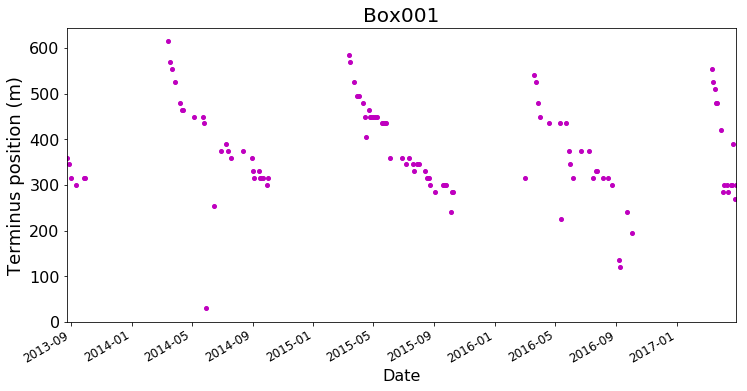

In [1178]:
#PLOT TERMINUS POSITION 
ax = df_BOI_merged.plot(x='datetimes', y='term_position', color='m', marker='o', linestyle = 'None', figsize=(12,6), legend=None, markersize=4)
# ax = df_BOI_merged.plot(x='datetimes', y='term_position', color='c', marker='o', linestyle = 'None', figsize=(12,6), legend=None, markersize=4)
# firstpass.plot(x='datetimes', y='term_position', style='ko', ax=ax, legend=None, markersize=4)
# ax = firstpass.plot(x='datetimes', y='term_position', style='mo', figsize=(12,6), legend=None, markersize=4)
# df_BOI_s.plot(x='datetimes', y='xdist_midpoint', style='co-', ax=ax)
plt.ylabel('Terminus position (m)', fontsize=18)

# #PLOT TERMINUS CHANGE
# # drop any Nan values since they won't plot properly
# df_BOI_merged = df_BOI_merged.dropna()

# ax = df_BOI_merged.plot(x='datetimes', y='changerates', style='bo', figsize=(12,6), legend=None)
# plt.ylabel('Terminus change rate (m/d)', fontsize=18)

#PLOT PERCENT CLOUD
# df_BOI_m.Cloudpercent = df_BOI_m.Cloudpercent.astype(float)
# ax = df_BOI_m.plot(x='datetimes', y='Cloudpercent', style='co', figsize=(12,6), legend=None)
# plt.ylabel('% Cloud', fontsize=18)

#PLOT AVGPIXEL PERCENT
# df_BOI_m.Avgpixel_percent = df_BOI_m.Avgpixel_percent.astype(float)
# ax = df_BOI_m.plot(x='datetimes', y='Avgpixel_percent', style='ko', figsize=(12,6), legend=None)
# plt.ylabel('Avg pixel value (% of max)', fontsize=18)


#GENERAL PLOT PARAMETERS
plt.title("Box"+BOI, fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
# plt.legend(labels=['Mass' ,'Size'])
# plt.legend(labels=['Mass'])

#SAVE FIGURE
#MASS
plt.savefig(basepath+"/Figures/Termposition_LS8_m_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"/Figures/Termchangerates_LS8_m_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"/Figures/Cloudpercent_LS8_m_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"/Figures/Avgpixval_LS8_m_Box"+BOI+".png", dpi=200)

#SIZE
# plt.savefig(basepath+"/Figures/Termposition_LS8_s_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"/Figures/Termchangerates_LS8_s_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"/Figures/Cloudpercent_LS8_s_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"/Figures/Avgpixval_LS8_s_Box"+BOI+".png", dpi=200)

plt.show()

_Remnant code to plot terminus change values over the terminus position points:_

In [202]:
# #LABEL EACH POINT BY TERMINUS CHANGE RATE
# for i, changerate_m in enumerate(df_BOI_m.index):
# #     print(type(changerate), changerate)
#     #If the rate is a float (number or Nan), format it
#     if isinstance(changerate_m, float):
#         txt = str("{0:.2f}".format(changerate_m))
#         #If it's positive, add a + for clarity:
#         if changerate_m > 0:
#             txt = "+"+txt
#         #don't plot the nans
#         if np.isnan(changerate_m):
#             txt = " "
#     #for others, plot the string
#     else:
#         txt = str(changerate_m)
#     plt.annotate(txt, 
#                  xy=(list(df_BOI_m['datetimes'])[i] ,list(df_BOI_m['xdist_midpoint'])[i]), 
#                  fontsize=12,
#                  xytext=(6 ,4), 
#                  textcoords='offset points',
#                  color='m')
# for i, changerate_s in enumerate(df_BOI_s.index):
# #     print(type(changerate), changerate)
#     #If the rate is a float (number or Nan), format it
#     if isinstance(changerate_s, float):
#         txt = str("{0:.2f}".format(changerate_s))
#         #If it's positive, add a + for clarity:
#         if changerate_s > 0:
#             txt = "+"+txt
#         #don't plot the nans
#         if np.isnan(changerate_s):
#             txt = " "
#     #for others, plot the string
#     else:
#         txt = str(changerate_s)
#     plt.annotate(txt, 
#                  xy=(list(df_BOI_s['datetimes'])[i] ,list(df_BOI_s['xdist_midpoint'])[i]), 
#                  fontsize=12,
#                  xytext=(6 ,-10), 
#                  textcoords='offset points',
#                  color='c')

### Plot image and seglines

In [193]:
#add dat file x and ys in as dataframes:

#get list of images
print("Box"+BOI)
pathtoimgs = '/media/jukes/jukes1/LS8aws/Box'+BOI+'/rotated/resized/'
imgfiles = os.listdir(pathtoimgs)
images = []
term_dats = []
imgnames = []

for imgfile in imgfiles:
    #grab image files and append to images list
    if imgfile.endswith(BOI+".png"):
        print(imgfile)
        image = mpimg.imread(pathtoimgs+imgfile)
        
        #grab dat files
        pathtodat = pathtoimgs+imgfile[0:-4]+".pgm_max_gaussian/terminus_highestmass/"
        datfiles = os.listdir(pathtodat)
        
        #if there is a dat file:
        if len(datfiles) > 0:
            #grab the dat file and read it in and append to the list
            datfile = datfiles[0]
            print(datfile)
            term_dat = np.loadtxt(pathtodat+datfile)
            term_dats.append(term_dat)
            print(term_dat.shape)
            #append the image name
            images.append(image)
            imgnames.append(imgfile)
        else:
            print("NO DAT FILE FOUND")
            

print(len(term_dats), len(images))

Box001
crop_R_LC80340052015106LGN00_B8_PS_Buffer001.png
terminus_highestmass_016.dat
(50, 2)
crop_R_LC80340052015218LGN00_B8_PS_Buffer001.png
terminus_highestmass_013.dat
(59, 2)
crop_R_LC80340052015202LGN00_B8_PS_Buffer001.png
terminus_highestmass_019.dat
(79, 2)
crop_R_LC80340052013148LGN00_B8_PS_Buffer001.png
terminus_highestmass_007.dat
(59, 2)
crop_R_LC80340052017095LGN00_B8_PS_Buffer001.png
terminus_highestmass_008.dat
(119, 2)
crop_R_LC80340052014183LGN00_B8_PS_Buffer001.png
terminus_highestmass_017.dat
(27, 2)
crop_R_LC80340052015266LGN00_B8_PS_Buffer001.png
terminus_highestmass_014.dat
(74, 2)
crop_R_LC80340052016253LGN00_B8_PS_Buffer001.png
terminus_highestmass_049.dat
(43, 2)
crop_R_LC80340052015090LGN00_B8_PS_Buffer001.png
terminus_highestmass_032.dat
(55, 2)
crop_R_LC80340052014263LGN00_B8_PS_Buffer001.png
terminus_highestmass_048.dat
(41, 2)
crop_R_LC80340052015122LGN00_B8_PS_Buffer001.png
terminus_highestmass_048.dat
(41, 2)
crop_R_LC80340052016141LGN00_B8_PS_Buffer001.p

crop_R_LC80340052015202LGN00_B8_PS_Buffer001.png average pixel value: 0.28562254
crop_R_LC80340052017095LGN00_B8_PS_Buffer001.png average pixel value: 0.36437362
crop_R_LC80340052016125LGN00_B8_PS_Buffer001.png average pixel value: 0.21688671
crop_R_LC80340052016189LGN00_B8_PS_Buffer001.png average pixel value: 0.24517418
crop_R_LC80340052016205LGN00_B8_PS_Buffer001.png average pixel value: 0.25504142
crop_R_LC80340052016173LGN00_B8_PS_Buffer001.png average pixel value: 0.31532618
crop_R_LC80340052014247LGN00_B8_PS_Buffer001.png average pixel value: 0.3339636
crop_R_LC80340052015154LGN00_B8_PS_Buffer001.png average pixel value: 0.2765246
crop_R_LC80340052016157LGN00_B8_PS_Buffer001.png average pixel value: 0.27350658
crop_R_LC80340052016237LGN00_B8_PS_Buffer001.png average pixel value: 0.34981853
crop_R_LC80340052016221LGN00_B8_PS_Buffer001.png average pixel value: 0.26537254
Lines: 11


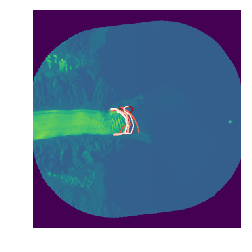

In [249]:
#imgplt = plt.imshow(images[40])
imgplt = plt.imshow(mpimg.imread('/home/jukes/Documents/Sample_glaciers/Box001/rotated_images/final/crop_PS_LC08_L1TP_031005_20180825_20180829_01_T1_B8_Buffer001cut.png'))
final_imgnames = []

xs = []
ys = []
for i in range(0, len(images)):
#     print(i)
    index = i
    #imgplt = plt.imshow(images[index])#cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB))\
    avgpxval = np.average(images[index])
   
    #if the pixel value is above a threshold, then grab the terminus
    if avgpxval < 0.37:
        final_imgnames.append(imgnames[index])
        print(imgnames[index], "average pixel value:", avgpxval)
        term = term_dats[index]
        term_xs = []
        term_ys = []

        #grab x and y values for the terminus line
        for j in term:
            x, y = (j[0], j[1])
            term_xs.append(x)
            term_ys.append(y)
        
        xs.append(term_xs)
        ys.append(term_ys)

#create dataframe with the term line coordinates and sort by date
termlines_df = pd.DataFrame(
    {'imgnames': final_imgnames,
     'X': xs,
     'Y': ys
    })

termlines_df = termlines_df.sort_values(by=['imgnames'])
termlines_df.head()

# #create reversed red color map for the lines
n=len(termlines_df.index)
print("Lines:", n)
colors = pl.cm.Reds_r(np.linspace(0,1,n))
col_count = 0

name = list(termlines_df['imgnames'])
x_final = list(termlines_df['X'])
y_final = list(termlines_df['Y'])

#plot each termline
for a in range(0, n):
    x, y = x_final[a], y_final[a]
    pl.plot(x, y, color=colors[col_count], linewidth=1)
    col_count = col_count+1

plt.axis("off")
plt.savefig(basepath+"/Figures/AGU2019_autolines_Box"+BOI+".png", dpi=300)

_Remnant code on plotting teminus changes:_

In [435]:
# #PLOT:
# plt.figure(figsize=(12, 8))
# plt.plot(changerates.keys(), changerates.values(),'rx', markersize=15)

# #Label the points by the change rate (m/d)
# for i, changerate in enumerate(changerates.values()):
#     txt = "{0:.2f}".format(changerate)
#     plt.annotate(txt, xy=(list(changerates.keys())[i], list(changerates.values())[i]), fontsize=16)

# plt.title("Box"+BOI, fontsize=20)
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Terminus change (m/d)', fontsize=18)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=16)
# plt.gca().invert_yaxis()

# plt.show()

#### Explore pick quality:

In [580]:
# print(df_BOI_m.shape)
# df_BOI_m.head()

In [581]:
# #list of datetimes associated with potentially bad picks 
# flag_dt = []
# termpositions = []
# termchangerates = []

# for index, row in df_BOI_m.iterrows():
#     date = row['datetimes']
#     scene = row['Scene']
#     cloudpercent = float(row['Cloudpercent'])
#     avgpixval = float(row['Avgpixel_percent'])
#     termposition = row['xdist_midpoint']
#     termchange = row['changerates']
    
#     if avgpixval > 40.0:
#         flag_dt.append(date)
#         termpositions.append(termposition)
#         termchangerates.append(termchange)
#         print(date, "flagged")

In [583]:
# print(termpositions)
# print(len(termpositions))

In [582]:
# badpick_clouds = []
# badpick_avgpix = []
# badpick_dates = []

# for index, row in df_BOI_m.iterrows():
#     date = row['datetimes']
#     scene = row['Scene']
#     cloudpercent = float(row['Cloudpercent'])
#     avgpixval = float(row['Avgpixel_percent'])
#     termposition = row['xdist_midpoint']
#     termchange = row['changerates']
    
#     if termposition < 500.0 or termposition > 1300.0: # or termchange > 100.0:
#         badpick_dates.append(date)
#         badpick_clouds.append(cloudpercent)
#         badpick_avgpix.append(avgpixval)
#         print(date, "flagged")

In [584]:
# print(badpick_avgpix)
# print(len(badpick_avgpix))
# # print(badpick_clouds)